## Step 1: Let's Get Some Images

For the sake of practice I won't be using the API here and instead scraping from the game-level pages on plays.tv

In [20]:
import urllib
from bs4 import BeautifulSoup
import csv
import requests
import os
from IPython.display import clear_output
import numpy as np
import cv2
import math
import sklearn
from matplotlib import pyplot as plt
from PIL import Image
import random
%matplotlib inline

In [3]:
# Frames per Game
FRAME_LIMIT = 250

def downloadVideo(name, url):
    r=requests.get(url)
    f=open(name,'wb')
    for chunk in r.iter_content(chunk_size=255): 
        if chunk: 
            f.write(chunk)
    f.close()
    
base_urls = {
    "csgo" : "https://plays.tv/game/CounterStrikeGlobalOffensive?game_id=04094bf1f162594b28707b50c4e8349e&page={}",
    "gta5" : "https://plays.tv/game/GrandTheftAutoV?game_id=65514104855d11e3aebc655d44bec87b&page={}",
    "dota2" : "https://plays.tv/game/Dota2?game_id=e9af38482c77a80a0688bbcab98a933f&page={}",
    "rs6" : "https://plays.tv/game/TomClancysRainbowSixSiege?game_id=114cdf56f27611e3a930b04744bec87b&page={}",
    "pubg" : "https://plays.tv/game/PLAYERUNKNOWNSBATTLEGROUNDS?game_id=beab9bd40164e6ed6101d7e0914b59e1&page={}",
    "fortnite" : "https://plays.tv/game/Fortnite?game_id=98ff5053ea366a4965ba7dbcfa10670c&page={}",
    "league" : "https://plays.tv/game/LeagueofLegends?game_id=b179585c6b68a2791eea4a1ad3d7ef72&page={}",
    "overwatch" : "https://plays.tv/game/Overwatch?game_id=101652c2d97f9a8d8872e7450f7daae6&sort=sort_popular&page={}"
}

if not os.path.exists('./playstvclips'):
    os.mkdir('playstvclips')
if not os.path.exists('./playstvscreenshots'):
    os.mkdir('playstvscreenshots')

images = {}

for key in base_urls.keys():
    images[key] = []
    n = 0
    frames = 0
    all_urls = []
    base_url = base_urls[key]

    for pages in range(10):
        if frames >= FRAME_LIMIT:
            continue
            
        page = base_url.format(str(pages))
        page_data = urllib.request.urlopen(page)
        soup = BeautifulSoup(page_data, "html.parser")
        urls = soup.findAll('source', limit=200)

        for url in [url for url in urls if '720' in url['src']]:
            if frames >= FRAME_LIMIT:
                continue
            # Status Check
            n+=1
            clear_output(wait=True)
            print(key + ' ' + str(n))
            
            # For VideoCapture to work it needs to be on disk...
            this_url = url['src'].replace('//', 'http://')
            file_name = './playstvclips/'+key+str(n)+'.mp4'
            downloadVideo(file_name, this_url)
            
            # Take screesnhots
            vidcap = cv2.VideoCapture(file_name)
            
            success, image = vidcap.read()
            #print(success)
            count = 0
            while success and frames < FRAME_LIMIT:
                # One frame per second
                vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
                #cv2.imwrite('./playstvscreenshots/video{}frame{}.jpg'.format(str(n), str(count)), image)
                images[key].append(cv2.resize(image,(144, 96)))
                success,image = vidcap.read()
                
                count += 1
                frames += 1
            
            
            


overwatch 5


## We should now have a dictionary keyed on game name with an array of images as the value

Let's check the first entries

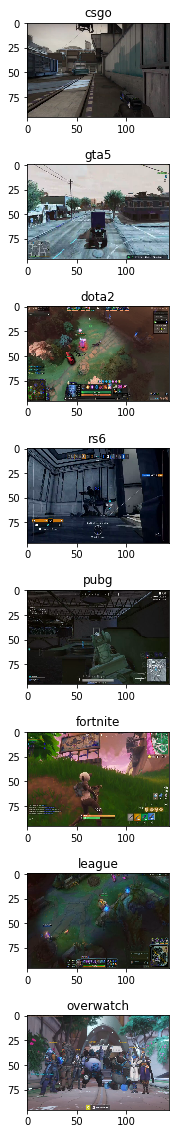

In [4]:
games = len(base_urls.keys())
fig = plt.figure(figsize=(games*50, 20))
fig.subplots_adjust(hspace=.5)
for idx, key in enumerate(base_urls.keys()):
    fig.add_subplot(games, 1, idx+1)
    plt.title(key)
    plt.imshow(images[key][0])

In [5]:
print("Check record counts")
for g in base_urls.keys():
    print("{} : {}".format(g, len(images[g])))

Check record counts
csgo : 250
gta5 : 250
dota2 : 250
rs6 : 250
pubg : 250
fortnite : 250
league : 250
overwatch : 250


## OK! ML Time.

For starters let's use Tensorflow's Keras API to train a basic perceptron and see how well it can differentiate these!


In [9]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.VERSION)
print(tf.keras.__version__)
from tensorflow.keras.models import *
from tensorflow.keras.layers import  *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical


1.12.0
2.1.6-tf


In [10]:
print("We have {} games".format(games))

We have 8 games


In [12]:
# Simple Model
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[96, 144, 1]))
model.add(Conv2D(filters=32, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=50, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=80, kernel_size=5, strides=1, padding='same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(games,activation='softmax'))


model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
def grey(images):
    return [np.asarray(Image.fromarray(i).convert('L')) for i in images]

base_data = []
base_labels = []

game_map = dict(zip(list(base_urls.keys()), range(games)))

for game in list(base_urls.keys()):
    base_data += grey(images[game])
    base_labels += [game_map[game]] * len(images[game])

data = np.array(base_data).reshape(-1, 96, 144, 1)
labels = to_categorical(base_labels, num_classes=games)

In [19]:
model.fit(data, labels, epochs = 10, batch_size=32)

Epoch 1/10
2000/2000 [==============================] - 14s 7ms/step - loss: 4.3107 - acc: 0.2490
Epoch 2/10
2000/2000 [==============================] - 13s 7ms/step - loss: 0.8168 - acc: 0.7305
Epoch 3/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2403 - acc: 0.9245
Epoch 4/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1109 - acc: 0.9645
Epoch 5/10
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0437 - acc: 0.9860
Epoch 6/10
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0559 - acc: 0.9845
Epoch 7/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0264 - acc: 0.9905
Epoch 8/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0444 - acc: 0.9855
Epoch 9/10
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0181 - acc: 0.9960
Epoch 10/10
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0398 - acc: 0.9875
